In [81]:
print('importing')

from helpers import misc_helpers

import logging

import torch
from torch import nn
from torch.optim.lr_scheduler import ReduceLROnPlateau

import numpy as np
from matplotlib import pyplot as plt

from more_itertools import collapse
from tqdm import tqdm

torch.set_default_device(misc_helpers.get_device())

print('done')

importing
done


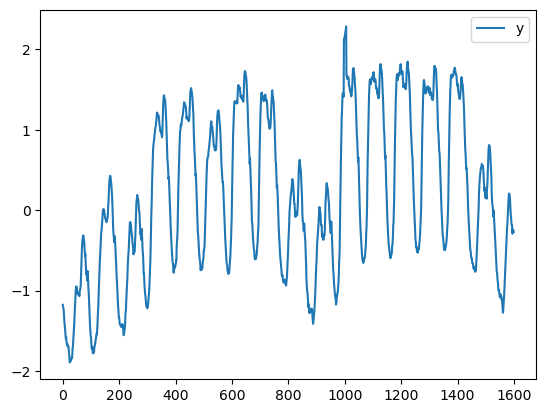

In [82]:
DATA_PATH = 'data/data_1600.pkl'
STANDARDIZE_DATA = True
PLOT_DATA = True
N_POINTS_PER_GROUP = 800

torch.set_default_dtype(torch.float32)

def get_clean_data(n_points_per_group, standardize_data, do_plot_data=True):
    X_train, X_test, y_train, y_test, X, y, _ = misc_helpers.get_data(
        DATA_PATH,
        n_points_per_group=n_points_per_group,
        standardize_data=standardize_data,
    )
    if do_plot_data:
        my_plot_data(X, y)
    return X_train, X_test, y_train, y_test, X, y

def my_plot_data(X, y):
    x_plot = np.arange(X.shape[0])
    if X.shape[-1] == 1:
        plt.plot(x_plot, X, label='X')
    plt.plot(x_plot, y, label='y')
    plt.legend()
    plt.show(block=True)

logging.info("loading data...")
X_train, X_test, y_train, y_test, X, y = get_clean_data(
    N_POINTS_PER_GROUP,
    standardize_data=STANDARDIZE_DATA,
    do_plot_data=PLOT_DATA
)
logging.info("data shapes:", X_train.shape, X_test.shape, y_train.shape, y_test.shape)

logging.info("running method...")
X_uq = np.row_stack((X_train, X_test))

In [83]:
QUANTILES = [0.05, 0.25, 0.75, 0.95]
N_ITER = 130
LR = 1e-4
REGULARIZATION = 1e-2
USE_SCHEDULER = True
LR_PATIENCE = 30
DO_PLOT_LOSSES = True

class QR_NN(nn.Module):
    def __init__(
        self,
        dim_in,
        quantiles,
        num_hidden_layers=2,
        hidden_layer_size=50,
        activation=torch.nn.LeakyReLU,
    ):
        """

        :param dim_in:
        :param quantiles: the quantile levels to predict
        :param num_hidden_layers:
        :param hidden_layer_size:
        :param activation:
        """
        super().__init__()
        self.quantiles = quantiles
        dim_out = len(quantiles)
        layers = collapse([
            nn.Linear(dim_in, hidden_layer_size),
            activation(),
            [[nn.Linear(hidden_layer_size, hidden_layer_size),
              activation()]
             for _ in range(num_hidden_layers)],
            nn.Linear(hidden_layer_size, dim_out),
        ])
        self.layer_stack = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor, as_dict=False):
        result = self.layer_stack(x)
        if as_dict:
            result = {quantile: result[:,i]
                      for i, quantile in enumerate(self.quantiles)}
        return result

#######

# defaults
n_iter=200
batch_size=20
random_seed=42
val_frac=0.1
lr=0.1
lr_patience=30
lr_reduction_factor=0.5
weight_decay=0.0
show_progress=True
do_plot_losses=True
plot_skip_losses=10
use_scheduler=True

# udpates
quantiles = QUANTILES
n_iter = N_ITER
lr = LR
lr_patience = LR_PATIENCE
regularization = REGULARIZATION
use_scheduler = USE_SCHEDULER
do_plot_losses = DO_PLOT_LOSSES

if 0.5 not in quantiles:
    quantiles.append(0.5)



def preprocess_array(array: np.ndarray):
    array = misc_helpers.np_array_to_tensor(array)
    array = misc_helpers.object_to_cuda(array)
    array = misc_helpers.make_tensor_contiguous(array)
    return array


def preprocess_arrays(*arrays: np.ndarray):
    return map(preprocess_array, arrays)


print('setup')
torch.manual_seed(random_seed)

print('train/val split')
X_train, y_train, X_val, y_val = misc_helpers.train_val_split(X_train, y_train, val_frac)
print([arr.shape for arr in [X_train, y_train, X_val, y_val]])
assert X_train.shape[0] > 0 and X_val.shape[0] > 0

print('preprocess arrays')
X_train, y_train, X_val, y_val = preprocess_arrays(X_train, y_train, X_val, y_val)
print([arr.shape for arr in [X_train, y_train, X_val, y_val]])
dim_in, dim_out = X_train.shape[-1], y_train.shape[-1]

quantiles = sorted(quantiles)

print('setup model')
model = QR_NN(
    dim_in,
    quantiles,
    num_hidden_layers=2,
    hidden_layer_size=50,
)
model = misc_helpers.object_to_cuda(model)
print('done')

setup
train/val split
[(720, 16), (720, 1), (80, 16), (80, 1)]
preprocess arrays
[torch.Size([720, 16]), torch.Size([720, 1]), torch.Size([80, 16]), torch.Size([80, 1])]
setup model
done


In [84]:
print('setup meta-stuff')
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = ReduceLROnPlateau(optimizer, patience=lr_patience, factor=lr_reduction_factor)
print('done')

setup meta-stuff
done


In [85]:
class MultiPinballLoss:
    def __init__(self, quantiles, reduction='mean'):
        if list(quantiles) != sorted(quantiles):
            raise ValueError(f'Quantiles must be sorted: {quantiles}')
        self.quantiles = quantiles
        self.reduction = reduction
        self.pinball_losses = [PinballLoss(quantile, reduction)
                               for quantile in self.quantiles]

    def __call__(self, y_pred_quantiles: torch.Tensor, y_true: torch.Tensor):
        # todo: optimize (with torch.vmap?)
        # todo: treat losses individually?
        assert y_pred_quantiles.shape[1] == len(self.pinball_losses)
        loss = torch.zeros_like(y_pred_quantiles, dtype=torch.float)
        for i, pinball_loss in enumerate(self.pinball_losses):
            loss[i] = pinball_loss(y_pred_quantiles[:, i:i+1], y_true)  # i+1 to ensure correct shape
        loss = reduce_loss(loss, self.reduction)
        return loss


class PinballLoss:
    """
    copied with minor changes from: https://github.com/ywatanabe1989/custom_losses_pytorch/blob/master/pinball_loss.py
    """
    def __init__(self, quantile, reduction='none'):
        """

        :param quantile:
        :param reduction: one of: 'mean', 'sum', 'none'
        """
        assert 0 <= quantile <= 1
        assert reduction in {'mean', 'sum', 'none'}
        self.quantile = quantile
        self.reduction = reduction

    def __call__(self, y_pred_quantile, y_true):
        assert y_pred_quantile.shape == y_true.shape
        loss = torch.zeros_like(y_true, dtype=torch.float)
        error = y_pred_quantile - y_true
        smaller_index = error < 0
        bigger_index = 0 < error
        abs_error = abs(error)
        loss[smaller_index] = self.quantile * abs_error[smaller_index]
        loss[bigger_index] = (1 - self.quantile) * abs_error[bigger_index]
        loss = reduce_loss(loss, self.reduction)
        return loss

def reduce_loss(loss, reduction):
    if reduction == 'sum':
        loss = loss.sum()
    elif reduction == 'mean':
        loss = loss.mean()
    return loss

criterion = MultiPinballLoss(quantiles, reduction='mean')
model.eval()
with torch.no_grad():
    print(criterion(model(X_train), y_train))

tensor(0.0032)


In [86]:
print('training')
# noinspection PyTypeChecker
train_loader = misc_helpers.get_train_loader(X_train, y_train, batch_size)
train_losses, val_losses = [], []
iterable = np.arange(n_iter) + 1
if show_progress:
    iterable = tqdm(iterable)
for _ in iterable:
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        optimizer.zero_grad()
        y_pred_quantiles = model(X_train_batch)
        loss = criterion(y_pred_quantiles, y_train_batch)
        loss.backward()
        optimizer.step()

    if not use_scheduler and not do_plot_losses:
        continue

    model.eval()
    with torch.no_grad():
        y_pred_quantiles_train = model(X_train)
        train_loss = criterion(y_pred_quantiles_train, y_train)
        train_losses.append(train_loss.item())

        y_pred_quantiles_val = model(X_val)
        val_loss = criterion(y_pred_quantiles_val, y_val)
        val_losses.append(val_loss.item())
    if use_scheduler:
        scheduler.step(val_loss)
model.eval()
print('done training')

training


100%|████████████████████████████████████████████████████████████████████████████████| 130/130 [04:14<00:00,  1.96s/it]

done training


plotting losses


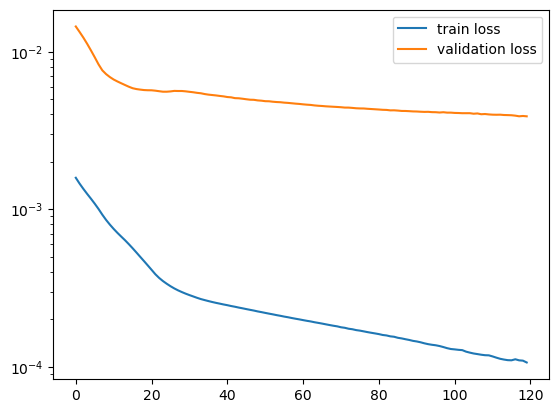

In [87]:
def has_neg(losses):
    return any(map(lambda x: x < 0, losses))

def plot_losses(train_losses, val_losses):
    fig, ax = plt.subplots()
    plt_func = ax.plot if has_neg(train_losses) or has_neg(val_losses) else ax.semilogy
    plt_func(train_losses, label="train loss")
    plt_func(val_losses, label="validation loss")
    ax.legend()
    plt.show(block=True)
    
if do_plot_losses:
    print('plotting losses')
    for loss_type, losses in {'train_losses': train_losses, 'val_losses': val_losses}.items():
        logging.info(loss_type, train_losses[:5], min(losses), max(losses), any(np.isnan(losses)))
    plot_losses(train_losses[plot_skip_losses:], val_losses[plot_skip_losses:])

In [88]:
# X_train: np.ndarray,
# y_train: np.ndarray,
# X_test: np.ndarray,
# quantiles: list,
# n_iter=100,
# lr=1e-4,
# lr_patience=5,
# regularization=0,
# do_plot_losses=False,
# use_scheduler=True,

print('evaluating')
qr_nn = model
X_uq = preprocess_array(X_uq)
X_uq.shape

evaluating


torch.Size([1600, 16])

In [89]:
with torch.no_grad():
    y_quantiles_dict = qr_nn(X_uq, as_dict=True)
y_quantiles = np.array(list(y_quantiles_dict.values())).T
y_pred = y_quantiles_dict[0.5]
y_std = None

display(y_quantiles.shape)
display(y_pred.shape)
display(y_std)

(1600, 5)

torch.Size([1600])

None

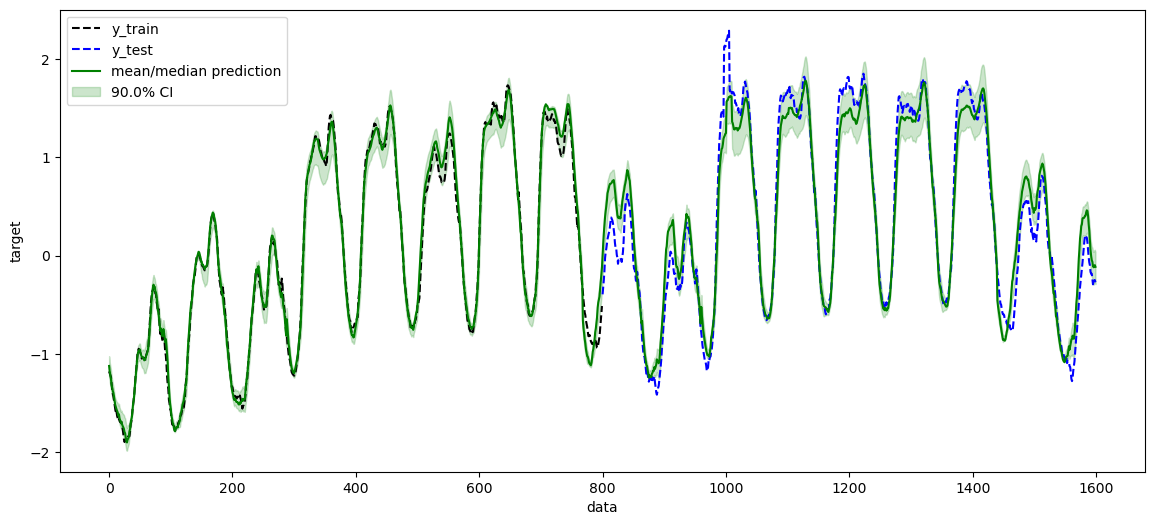

In [91]:
y_preds = y_pred

num_train_steps, num_test_steps = X_train.shape[0] + X_val.shape[0], X_test.shape[0]

x_plot_train = np.arange(num_train_steps)
x_plot_full = np.arange(num_train_steps + num_test_steps)
x_plot_test = np.arange(num_train_steps, num_train_steps + num_test_steps)
x_plot_uq = x_plot_full

y_train_full = np.row_stack((y_train, y_val))

drawing_std = y_quantiles is not None
if drawing_std:
    ci_low, ci_high = (
        y_quantiles[:, 0],
        y_quantiles[:, -1],
    )
    drawn_quantile = round(max(quantiles) - min(quantiles), 2)
else:
    ci_low, ci_high = y_preds - y_std, y_preds + y_std

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 6))
ax.plot(x_plot_train, y_train_full, label='y_train', linestyle="dashed", color="black")
ax.plot(x_plot_test, y_test, label='y_test', linestyle="dashed", color="blue")
ax.plot(
    x_plot_uq,
    y_preds,
    label=f"mean/median prediction",  # todo: mean or median?
    color="green",
)
# noinspection PyUnboundLocalVariable
label = rf"{f'{100 * drawn_quantile}% CI' if drawing_std else '1 std'}"
ax.fill_between(
    x_plot_uq.ravel(),
    ci_low,
    ci_high,
    color="green",
    alpha=0.2,
    label=label,
)
ax.legend()
ax.set_xlabel("data")
ax.set_ylabel("target")
plt.show(block=True)

In [103]:
# test-plot individual quantiles
%matplotlib notebook 
plt.ion()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 6))
ax.plot(x_plot_train, y_train_full, label='y_train', linestyle="dashed", color="black")
ax.plot(x_plot_test, y_test, label='y_test', linestyle="dashed", color="blue")
for quantile, y_quantile in y_quantiles_dict.items():
    ax.plot(x_plot_uq, y_quantile, label=f"predicted quantile {quantile}")
ax.legend()
ax.set_xlabel("data")
ax.set_ylabel("target")
plt.show()